In [ ]:
import json
import re

import numpy as np 
import pandas as pd
from keras.models import Model
from keras.layers import Input, Dense, Embedding, SpatialDropout1D, add, concatenate
from keras.layers import CuDNNLSTM, Bidirectional, GlobalMaxPooling1D, GlobalAveragePooling1D
from keras.callbacks import Callback, ModelCheckpoint
from keras.preprocessing import text, sequence
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [ ]:
tqdm.pandas()

# Preprocessing

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Loading data

In [ ]:
zomato_orgnl = pd.read_csv('gdrive/MyDrive/zomato_og.csv', encoding='latin-1')
zomato_orgnl = zomato_orgnl.iloc[:25000,:]
print(zomato_orgnl.shape)
zomato_orgnl.head()

(25000, 17)


,url,address,name,online_order,book_table,rate,votes,phone,location,rest_type,dish_liked,cuisines,approx_cost(for two people),reviews_list,menu_item,listed_in(type),listed_in(city)
0,https://www.zomato.com/bangalore/jalsa-banasha...,"942, 21st Main Road, 2nd Stage, Banashankari, ...",Jalsa,Yes,Yes,4.1/5,775,080 42297555\r\n+91 9743772233,Banashankari,Casual Dining,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...","North Indian, Mughlai, Chinese",800,"[('Rated 4.0', 'RATED\n A beautiful place to ...",[],Buffet,Banashankari
1,https://www.zomato.com/bangalore/spice-elephan...,"2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...",Spice Elephant,Yes,No,4.1/5,787,080 41714161,Banashankari,Casual Dining,"Momos, Lunch Buffet, Chocolate Nirvana, Thai G...","Chinese, North Indian, Thai",800,"[('Rated 4.0', 'RATED\n Had been here for din...",[],Buffet,Banashankari
2,https://www.zomato.com/SanchurroBangalore?cont...,"1112, Next to KIMS Medical College, 17th Cross...",San Churro Cafe,Yes,No,3.8/5,918,+91 9663487993,Banashankari,"Cafe, Casual Dining","Churros, Cannelloni, Minestrone Soup, Hot Choc...","Cafe, Mexican, Italian",800,"[('Rated 3.0', ""RATED\n Ambience is not that ...",[],Buffet,Banashankari
3,https://www.zomato.com/bangalore/addhuri-udupi...,"1st Floor, Annakuteera, 3rd Stage, Banashankar...",Addhuri Udupi Bhojana,No,No,3.7/5,88,+91 9620009302,Banashankari,Quick Bites,Masala Dosa,"South Indian, North Indian",300,"[('Rated 4.0', ""RATED\n Great food and proper...",[],Buffet,Banashankari
4,https://www.zomato.com/bangalore/grand-village...,"10, 3rd Floor, Lakshmi Associates, Gandhi Baza...",Grand Village,No,No,3.8/5,166,+91 8026612447\r\n+91 9901210005,Basavanagudi,Casual Dining,"Panipuri, Gol Gappe","North Indian, Rajasthani",600,"[('Rated 4.0', 'RATED\n Very good restaurant ...",[],Buffet,Banashankari


In [ ]:
#Deleting Unnnecessary Columns
zomato=zomato_orgnl.drop(['url','dish_liked','phone'],axis=1) 

In [ ]:
#Removing the Duplicates
zomato.duplicated().sum()
zomato.drop_duplicates(inplace=True)

In [ ]:
zomato

,address,name,online_order,book_table,rate,votes,location,rest_type,cuisines,approx_cost(for two people),reviews_list,menu_item,listed_in(type),listed_in(city)
0,"942, 21st Main Road, 2nd Stage, Banashankari, ...",Jalsa,Yes,Yes,4.1/5,775,Banashankari,Casual Dining,"North Indian, Mughlai, Chinese",800,"[('Rated 4.0', 'RATED\n A beautiful place to ...",[],Buffet,Banashankari
1,"2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...",Spice Elephant,Yes,No,4.1/5,787,Banashankari,Casual Dining,"Chinese, North Indian, Thai",800,"[('Rated 4.0', 'RATED\n Had been here for din...",[],Buffet,Banashankari
2,"1112, Next to KIMS Medical College, 17th Cross...",San Churro Cafe,Yes,No,3.8/5,918,Banashankari,"Cafe, Casual Dining","Cafe, Mexican, Italian",800,"[('Rated 3.0', ""RATED\n Ambience is not that ...",[],Buffet,Banashankari
3,"1st Floor, Annakuteera, 3rd Stage, Banashankar...",Addhuri Udupi Bhojana,No,No,3.7/5,88,Banashankari,Quick Bites,"South Indian, North Indian",300,"[('Rated 4.0', ""RATED\n Great food and proper...",[],Buffet,Banashankari
4,"10, 3rd Floor, Lakshmi Associates, Gandhi Baza...",Grand Village,No,No,3.8/5,166,Basavanagudi,Casual Dining,"North Indian, Rajasthani",600,"[('Rated 4.0', 'RATED\n Very good restaurant ...",[],Buffet,Banashankari
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,"117/1, Near Shilpa Bakery, Horamavu - Agara Ma...",Teapoy Mutiny,Yes,No,4.1/5,98,Hennur,Cafe,"Cafe, Continental, American, Beverages",500,"[('Rated 4.0', ""RATED\n Nice place to hangout...",[],Dine-out,Kalyan Nagar
24996,"544, 3rd Main, 4th Cross, OMBR Layout, Banaswa...",Patio - The Resto Cafe,Yes,No,3.7/5,73,Banaswadi,"Cafe, Quick Bites","Cafe, Continental, Chinese, Momos",500,"[('Rated 5.0', 'RATED\n The place has a nice ...","['Veg Steamed Momos', 'Chicken Shanghai Fried ...",Dine-out,Kalyan Nagar
24997,"653,/2, Annaiah Reddy Layout, 100 Feet Road, B...",Sufi Restaurant & Cafe,Yes,No,3.7/5,105,Banaswadi,Casual Dining,"Iranian, Mughlai, Chinese",800,"[('Rated 3.0', 'RATED\n Nice place for take a...","['Soup E Jo Morgh', 'Kabab E Koobideh', 'Kabab...",Dine-out,Kalyan Nagar
24998,"1253, Near Horamavu Signal, Outer Ring Road, D...",Bhagini,Yes,No,2.3/5,119,Banaswadi,Casual Dining,"Andhra, South Indian, Chinese, North Indian",800,"[('Rated 2.0', ""RATED\n Fancy exterior with a...","['Chicken 65', 'Veg Biryani', 'Egg Biryani', '...",Dine-out,Kalyan Nagar


In [ ]:
#Remove the NaN values from the dataset
zomato.isnull().sum()
zomato.dropna(how='any',inplace=True)
zomato.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21113 entries, 0 to 24999
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   address                      21113 non-null  object
 1   name                         21113 non-null  object
 2   online_order                 21113 non-null  object
 3   book_table                   21113 non-null  object
 4   rate                         21113 non-null  object
 5   votes                        21113 non-null  int64 
 6   location                     21113 non-null  object
 7   rest_type                    21113 non-null  object
 8   cuisines                     21113 non-null  object
 9   approx_cost(for two people)  21113 non-null  object
 10  reviews_list                 21113 non-null  object
 11  menu_item                    21113 non-null  object
 12  listed_in(type)              21113 non-null  object
 13  listed_in(city)              21

In [ ]:
#Changing the Columns Names
zomato.columns
zomato = zomato.rename(columns={'approx_cost(for two people)':'cost','listed_in(type)':'type',
                                  'listed_in(city)':'city'})
zomato.columns

Index(['address', 'name', 'online_order', 'book_table', 'rate', 'votes',
       'location', 'rest_type', 'cuisines', 'cost', 'reviews_list',
       'menu_item', 'type', 'city'],
      dtype='object')

In [ ]:
zomato

,address,name,online_order,book_table,rate,votes,location,rest_type,cuisines,cost,reviews_list,menu_item,type,city
0,"942, 21st Main Road, 2nd Stage, Banashankari, ...",Jalsa,Yes,Yes,4.1/5,775,Banashankari,Casual Dining,"North Indian, Mughlai, Chinese",800,"[('Rated 4.0', 'RATED\n A beautiful place to ...",[],Buffet,Banashankari
1,"2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...",Spice Elephant,Yes,No,4.1/5,787,Banashankari,Casual Dining,"Chinese, North Indian, Thai",800,"[('Rated 4.0', 'RATED\n Had been here for din...",[],Buffet,Banashankari
2,"1112, Next to KIMS Medical College, 17th Cross...",San Churro Cafe,Yes,No,3.8/5,918,Banashankari,"Cafe, Casual Dining","Cafe, Mexican, Italian",800,"[('Rated 3.0', ""RATED\n Ambience is not that ...",[],Buffet,Banashankari
3,"1st Floor, Annakuteera, 3rd Stage, Banashankar...",Addhuri Udupi Bhojana,No,No,3.7/5,88,Banashankari,Quick Bites,"South Indian, North Indian",300,"[('Rated 4.0', ""RATED\n Great food and proper...",[],Buffet,Banashankari
4,"10, 3rd Floor, Lakshmi Associates, Gandhi Baza...",Grand Village,No,No,3.8/5,166,Basavanagudi,Casual Dining,"North Indian, Rajasthani",600,"[('Rated 4.0', 'RATED\n Very good restaurant ...",[],Buffet,Banashankari
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,"117/1, Near Shilpa Bakery, Horamavu - Agara Ma...",Teapoy Mutiny,Yes,No,4.1/5,98,Hennur,Cafe,"Cafe, Continental, American, Beverages",500,"[('Rated 4.0', ""RATED\n Nice place to hangout...",[],Dine-out,Kalyan Nagar
24996,"544, 3rd Main, 4th Cross, OMBR Layout, Banaswa...",Patio - The Resto Cafe,Yes,No,3.7/5,73,Banaswadi,"Cafe, Quick Bites","Cafe, Continental, Chinese, Momos",500,"[('Rated 5.0', 'RATED\n The place has a nice ...","['Veg Steamed Momos', 'Chicken Shanghai Fried ...",Dine-out,Kalyan Nagar
24997,"653,/2, Annaiah Reddy Layout, 100 Feet Road, B...",Sufi Restaurant & Cafe,Yes,No,3.7/5,105,Banaswadi,Casual Dining,"Iranian, Mughlai, Chinese",800,"[('Rated 3.0', 'RATED\n Nice place for take a...","['Soup E Jo Morgh', 'Kabab E Koobideh', 'Kabab...",Dine-out,Kalyan Nagar
24998,"1253, Near Horamavu Signal, Outer Ring Road, D...",Bhagini,Yes,No,2.3/5,119,Banaswadi,Casual Dining,"Andhra, South Indian, Chinese, North Indian",800,"[('Rated 2.0', ""RATED\n Fancy exterior with a...","['Chicken 65', 'Veg Biryani', 'Egg Biryani', '...",Dine-out,Kalyan Nagar


In [ ]:
#Some Transformations
zomato['cost'] = zomato['cost'].astype(str)
zomato['cost'] = zomato['cost'].apply(lambda x: x.replace(',','.'))
zomato['cost'] = zomato['cost'].astype(float)
zomato.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21113 entries, 0 to 24999
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   address       21113 non-null  object 
 1   name          21113 non-null  object 
 2   online_order  21113 non-null  object 
 3   book_table    21113 non-null  object 
 4   rate          21113 non-null  object 
 5   votes         21113 non-null  int64  
 6   location      21113 non-null  object 
 7   rest_type     21113 non-null  object 
 8   cuisines      21113 non-null  object 
 9   cost          21113 non-null  float64
 10  reviews_list  21113 non-null  object 
 11  menu_item     21113 non-null  object 
 12  type          21113 non-null  object 
 13  city          21113 non-null  object 
dtypes: float64(1), int64(1), object(12)
memory usage: 2.4+ MB


In [ ]:
#Removing '/5' from Rates
zomato['rate'].unique()
zomato = zomato.loc[zomato.rate !='NEW']
zomato = zomato.loc[zomato.rate !='-'].reset_index(drop=True)
remove_slash = lambda x: x.replace('/5', '') if type(x) == np.str else x
zomato.rate = zomato.rate.apply(remove_slash).str.strip().astype('float')
zomato['rate'].head()

0    4.1
1    4.1
2    3.8
3    3.7
4    3.8
Name: rate, dtype: float64

In [ ]:
df = zomato.copy()

## Retrieve the text data

In [ ]:
all_ratings = []

for ratings in tqdm(df['reviews_list']):
    ratings = eval(ratings)
    
    for score, doc in ratings:
        if score:
            score = score.strip("Rated").strip()
            doc = doc.strip('RATED').strip()
            
            score = float(score)
            all_ratings.append([score, doc])

100%|██████████| 19753/19753 [00:06<00:00, 3104.49it/s]


In [ ]:
ratings_df = pd.DataFrame(all_ratings, columns=['score', 'doc'])

print(ratings_df.shape)
ratings_df.head()

(548818, 2)


,score,doc
0,4.0,A beautiful place to dine in.The interiors tak...
1,4.0,I was here for dinner with my family on a week...
2,2.0,Its a restaurant near to Banashankari BDA. Me ...
3,4.0,We went here on a weekend and one of us had th...
4,5.0,The best thing about the place is itÃÂÃÂ...


## Remove ratings inside text

Some of the reviews have ratings within it. We want to train a generic model to predict ratings with only text, so we want to hide this extra information so the model does not overfit on that.

"Unhide" the output of the next cell to view sample of the ratings that contain the character `"/"`.

In [ ]:
docs_with_ratings = []
for doc in ratings_df['doc'][:150]:
    if '/' in doc:
        print(doc)
        docs_with_ratings.append(doc)

Great food and pleasant ambience. Expensive but Coll place to chill and relax......

Service is really very very good and friendly staff...

Food : 5/5
Service : 5/5
Ambience :5/5
Overall :5/5
I was looking for a quite place to spend some time with family and as well wanted to try some new place. Since I was at Banashankari I thought of trying this place. The place had good rating and was part of Zomato gold. So I decided to try this place. It was a delite to see a very friendly staff and food we ordered was very tasty as well.

Food : 4/5
Ambience :3/5
Friendly staff : 4/5
Pocket friendly : 4/5

Will definitely visit again ??
Food: 8/10
Ambience:8/10
Staff:8/10
One of the good places to try north Indian food...but depends on ur taste buds. Not everyone will like all the items here. Specially when u r particular abt sweet and spicy food.
There's buffet available too.
We had ordered paneer uttar dakshin and paneer kurchan..was amazing. The Gobi hara pyaz and mix veg were average.
One of

In [ ]:
print(len(docs_with_ratings))

26


We will use Regex to find and replace all the occurences of ratings. 

Let's take a look at all the parts of documents that matches the pattern `[0-9.]*[0-9]/[0-9]*[0-9]`, which correspond to any rating that has double digits (e.g. 10/10), single digits (5/5) or single digits with a fraction (e.g. 9.5/10 or 3.5/5).

In [ ]:
for docs in docs_with_ratings:
    x = re.findall('[0-9.]*[0-9]/[0-9]*[0-9]', docs)
    print(x)

['5/5', '5/5', '5/5', '5/5']
['4/5', '3/5', '4/5', '4/5']
['8/10', '8/10', '8/10']
['6/10', '7/10', '8/10', '7.5/10']
[]
[]
[]
[]
['4/5', '3.5/5', '4/5', '4/5']
['3/5', '3/5', '3/5']
['10/10', '10/10', '10/10', '25/10']
['4/5', '10/5']
['4/5', '4/5', '4/5']
['4/5', '10/5']
['4/5', '4/5', '4/5']
['4/5', '10/5']
['4/5', '4/5', '4/5']
['4/5', '10/5']
['4/5', '4/5', '4/5']
['4/5', '10/5']
['4/5', '4/5', '4/5']
['4/5', '10/5']
['4/5', '4/5', '4/5']
['4.5/5', '4/5', '4.5/5', '4.5/5']
['3.5/5', '4/5', '3.5/5']
['3.5/5', '4/5', '3.5/5']


We will replace them with the word "score", since we do not want the model to overfit on ratings that are already given in the comments.

In [ ]:
doc = docs_with_ratings[0]
subbed_doc = re.sub('[0-9.]*[0-9]/[0-9]*[0-9]', 'score', doc)
print("ORIGINAL:")
print(doc)
print("\nSUBBED:")
print(subbed_doc)

ORIGINAL:
Great food and pleasant ambience. Expensive but Coll place to chill and relax......

Service is really very very good and friendly staff...

Food : 5/5
Service : 5/5
Ambience :5/5
Overall :5/5

SUBBED:
Great food and pleasant ambience. Expensive but Coll place to chill and relax......

Service is really very very good and friendly staff...

Food : score
Service : score
Ambience :score
Overall :score


Now, we do it for all texts.

In [ ]:
ratings_df.head()

,score,doc
0,4.0,A beautiful place to dine in.The interiors tak...
1,4.0,I was here for dinner with my family on a week...
2,2.0,Its a restaurant near to Banashankari BDA. Me ...
3,4.0,We went here on a weekend and one of us had th...
4,5.0,The best thing about the place is itÃÂÃÂ...


## Text Preprocessing

In [ ]:
ratings_df.head()

,score,doc
0,4.0,A beautiful place to dine in.The interiors tak...
1,4.0,I was here for dinner with my family on a week...
2,2.0,Its a restaurant near to Banashankari BDA. Me ...
3,4.0,We went here on a weekend and one of us had th...
4,5.0,The best thing about the place is itÃÂÃÂ...


In [ ]:
## Lower Casing
ratings_df['review'] = ratings_df['doc'].str.lower()

In [ ]:
import string
PUNCT_TO_REMOVE = string.punctuation
def remove_punctuation(text):
    """custom function to remove the punctuation"""
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

ratings_df['review'] = ratings_df['review'].apply(lambda text: remove_punctuation(text))

In [ ]:
ratings_df=ratings_df.drop(['doc'],axis=1) 

In [ ]:
## Removal of Stopwords
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
STOPWORDS = set(stopwords.words('english'))
def remove_stopwords(text):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

ratings_df['review'] = ratings_df['review'].apply(lambda text: remove_stopwords(text))
ratings_df.sample()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,score,review
261836,1.0,tonight parents ordered makkai potli shorba ma...


In [ ]:
## Removal of urls
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

ratings_df['review'] = ratings_df['review'].apply(lambda text: remove_urls(text))
ratings_df.sample(3)

,score,review
447532,5.0,sambram biriyani paradise located jp nagar 3rd...
335767,4.0,everything ok except packing
272071,4.5,nice cafe good ambience wood fired pizza place...


## One Hot Encoding

Let's look at the distribution of ratings

In [ ]:
ratings_df['score'].astype('category').value_counts()

4.0    161783
5.0    152642
3.0     77925
1.0     69592
2.0     29134
3.5     25087
4.5     20943
2.5      7602
1.5      4110
Name: score, dtype: int64

Clearly this is categorical data, with some heavy class imbalance. This is something to address if you want to improve performance. We will go ahead and encode that into binary labels:

In [ ]:
dummies = pd.get_dummies(ratings_df['score'])
dummies.head()

,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0
0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,1,0,0
2,0,0,1,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,1


## Train Test Split

Finally, we split the data into train and test sets; the latter will be used to evaluate our model.

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(
    ratings_df['review'], 
    dummies, 
    test_size=0.1, random_state=19
)

# Building an LSTM Model

At this point, we are ready to build our model. Similar to the original kernel, we will go through the following steps:
1. Fit the Keras Tokenizer
2. Build an embedding matrix
3. Tokenize and pad our training data
4. Train the model

Once we are done training the model, we evaluate how well it performs. This part is covered in the next section.

## Helper functions to create fasttext embedding

In [ ]:
def build_matrix(word_index, path):
    def get_coefs(word, *arr):
        return word, np.asarray(arr, dtype='float32')

    def load_embeddings(path):
        with open(path) as f:
            embedding_index = {}
            
            for line in tqdm(f):
                word, arr = get_coefs(*line.strip().split(' '))    
                if word in word_index:
                    embedding_index[word] = arr
            
        return embedding_index

    embedding_index = load_embeddings(path)
    embedding_matrix = np.zeros((len(word_index) + 1, 300))
    
    for word, i in tqdm(word_index.items()):
        try:
            embedding_matrix[i] = embedding_index[word]
        except KeyError:
            pass
    return embedding_matrix

In [ ]:
def build_model(embedding_matrix):
    words = Input(shape=(None,))
    x = Embedding(*embedding_matrix.shape, weights=[embedding_matrix], trainable=False)(words)
    x = SpatialDropout1D(0.3)(x)
    x = Bidirectional(CuDNNLSTM(256, return_sequences=True))(x)

    hidden = concatenate([
        GlobalMaxPooling1D()(x),
        GlobalAveragePooling1D()(x),
    ])
    hidden = Dense(512, activation='relu')(hidden)
    result = Dense(9, activation='softmax')(hidden)
    
    model = Model(inputs=words, outputs=result)
    model.compile(
        loss='categorical_crossentropy', 
        optimizer='adam',
        metrics=['accuracy']
    )

    return model

## Creating the tokenizer

In [ ]:
%%time
CHARS_TO_REMOVE = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n“”’\'∞θ÷α•à−β∅³π‘₹´°£€\×™√²—'
tokenizer = text.Tokenizer(filters=CHARS_TO_REMOVE)
tokenizer.fit_on_texts(list(x_train) + list(x_test))

CPU times: user 21 s, sys: 49.8 ms, total: 21.1 s
Wall time: 21.1 s


In [ ]:
!unzip "gdrive/MyDrive/crawl-300d-2M.vec.zip" -d "crawl-300d-2M"

Archive:  gdrive/MyDrive/crawl-300d-2M.vec.zip
  inflating: crawl-300d-2M/crawl-300d-2M.vec  


In [ ]:
embedding_matrix = build_matrix(tokenizer.word_index, 'crawl-300d-2M/crawl-300d-2M.vec')

2000001it [02:33, 13006.25it/s]
100%|██████████| 77816/77816 [00:00<00:00, 664304.23it/s]


In [ ]:
x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)
x_train = sequence.pad_sequences(x_train, maxlen=384)
x_test = sequence.pad_sequences(x_test, maxlen=384)

## Training

In [ ]:
import tensorflow as tf

In [ ]:
tf.test.is_gpu_available(
    cuda_only=False,
    min_cuda_compute_capability=None
)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [ ]:
model = build_model(embedding_matrix)
model.summary()

checkpoint = ModelCheckpoint(
    'model.h5', 
    monitor='val_accuracy', 
    verbose=1, 
    save_best_only=True, 
    save_weights_only=False,
    mode='auto'
)

history = model.fit(
    x_train,
    y_train,
    batch_size=512,
    callbacks=[checkpoint],
    epochs=10,
    validation_split=0.1
)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 300)    23345100    ['input_1[0][0]']                
                                                                                                  
 spatial_dropout1d (SpatialDrop  (None, None, 300)   0           ['embedding[0][0]']              
 out1D)                                                                                           
                                                                                                  
 bidirectional (Bidirectional)  (None, None, 512)    1142784     ['spatial_dropout1d[0][0]']  

# Evaluation

## Training history

Let's take a look at how well the model is training.

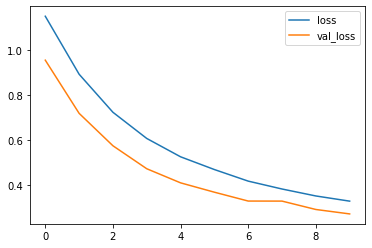

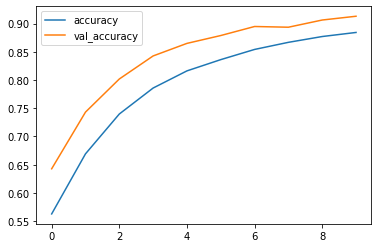

In [ ]:
with open('history.json', 'w') as f:
    json.dump(history.history, f)

history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
history_df[['accuracy', 'val_accuracy']].plot()

In [ ]:
from sklearn import metrics

In [ ]:
predict_test = model.predict(x_test)
predict_train = model.predict(x_train)

In [ ]:
predict_test

array([[2.4689834e-05, 1.0823274e-07, 3.0580592e-05, ..., 2.3775175e-03,
        7.9739717e-04, 9.9666816e-01],
       [7.6354980e-02, 5.0344155e-03, 2.3261440e-01, ..., 4.5354120e-02,
        8.9797052e-04, 9.7460480e-04],
       [4.9437593e-05, 5.6984646e-07, 2.6579480e-06, ..., 4.8026852e-02,
        3.0984100e-02, 9.2083675e-01],
       ...,
       [6.5755812e-05, 2.2340504e-12, 2.3714867e-03, ..., 9.8972565e-01,
        2.2921205e-09, 2.3549162e-04],
       [3.8999475e-09, 1.5582771e-11, 1.0349806e-06, ..., 9.9858391e-01,
        6.7083597e-06, 4.1910642e-04],
       [1.7319027e-12, 2.1068892e-15, 6.9171604e-12, ..., 1.0217304e-03,
        8.7972009e-04, 9.9809831e-01]], dtype=float32)

In [ ]:
predict_train

array([[1.3659445e-12, 2.1171247e-13, 9.1992525e-12, ..., 1.4225695e-03,
        2.8333522e-04, 9.9828929e-01],
       [2.3897488e-01, 7.0844781e-06, 4.0348998e-01, ..., 1.7832662e-01,
        7.4618983e-06, 4.8598975e-02],
       [3.6229626e-06, 1.9326396e-09, 4.3247263e-05, ..., 1.8642258e-02,
        5.0582348e-05, 9.8008394e-01],
       ...,
       [2.9675574e-03, 1.5988167e-06, 9.8181939e-01, ..., 2.6874333e-05,
        2.1885324e-14, 8.3298767e-12],
       [6.0510949e-08, 2.1091769e-11, 1.2221953e-02, ..., 3.9009628e-05,
        1.2307390e-15, 5.6576532e-15],
       [5.1339885e-07, 9.5716324e-09, 2.4934346e-04, ..., 4.0810235e-04,
        3.8030760e-07, 1.2478288e-06]], dtype=float32)

In [ ]:
print("Test R2: {0:.4f}".format(metrics.r2_score(y_test, predict_test)))
print("Train R2: {0:.4f}".format(metrics.r2_score(y_train, predict_train)))
print()
print("Test MSE: {0:.4f}".format(metrics.mean_squared_error(y_test, predict_test)))
print("Train MSE: {0:.4f}".format(metrics.mean_squared_error(y_train, predict_train)))
print()
print("Test RMSE: {0:.4f}".format(metrics.mean_squared_error(y_test, predict_test) ** 0.5))
print("Train RMSE: {0:.4f}".format(metrics.mean_squared_error(y_train, predict_train) ** 0.5))
print()


Test R2: 0.8322
Train R2: 0.8899

Test MSE: 0.0144
Train MSE: 0.0098

Test RMSE: 0.1200
Train RMSE: 0.0989



## End of the notebook